In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [4]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [18]:
vstack([Table.read('./Catalog/mock_sample/mock_obj_cat.fits'),
        Table.read('./Catalog/mock_sample/mock_obj_cat_2.fits'),
        Table.read('./Catalog/mock_sample/mock_obj_cat_3.fits')]
      ).write('./Catalog/mock_sample/mock_obj_cat_all.fits', overwrite=True)

In [6]:
lsbg_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_3.fits')
# lsbg_cat['image_flag'] = np.ones(len(lsbg_cat), dtype=bool)
# lsbg_cat['psf_flag'] = np.ones(len(lsbg_cat), dtype=bool)
print('# of LSBGs:', len(lsbg_cat))

# of LSBGs: 100


In [11]:
lsbg = lsbg_cat[2]

In [12]:
lsbg

<Row index=2>
viz-id         ra                dec            mag_auto_i         sersic_n          sersic_ell          sersic_PA      sersic_rhalf_circ              sersic_sed [4]                              mags [4]                                           prefix                           image_flag [4] psf_flag [4]
int64       float64            float64           float64           float64            float64             float64            float64                      float64                                  float64                                           bytes65                                bool          bool    
------ ------------------ ----------------- ------------------ ---------------- ------------------- ------------------- ----------------- ---------------------------------------- --------------------------------------- ----------------------------------------------------------- -------------- ------------
   102 235.45041589875865 43.73213270597782 20.702300908660597 1.34778350091691 0.23800883596338873 -42.323359143257065 5.155809228787272 0.6276584173261123 .. 1.0823858855261164 21.20799251520019 .. 20.616345607756916 /tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_102   True .. True True .. True

### Running scarlet vanilla modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_102`
    Working directory: /tigress/jiaxuanl/Data/HSC/LSBG
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    3 stars from Gaia are masked!
    Detected 159 objects
    3 stars from Gaia are masked!
    Detected 129 objects
    Detected 75 objects
    Total number of sources: 11
    Optimizaiton: Succeed for e_rel = 0.0001 with 46 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 86 iterations! Try higher accuracy!
  - After 28 iterations, logL = 1303596.18
    Elapsed time for fitting: 23.13 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /tigress/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-102-trained-model-vanilla.df


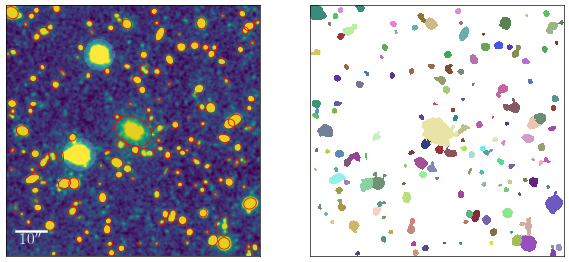

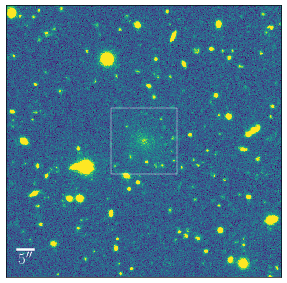

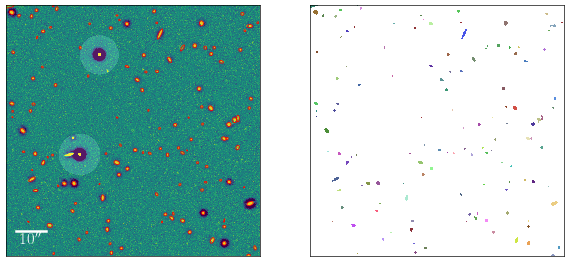

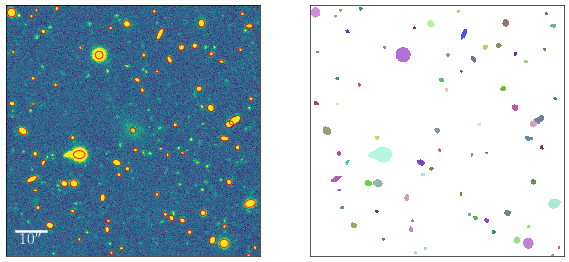

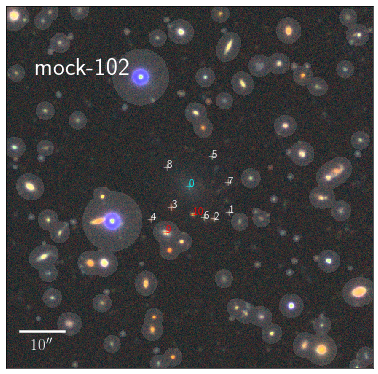

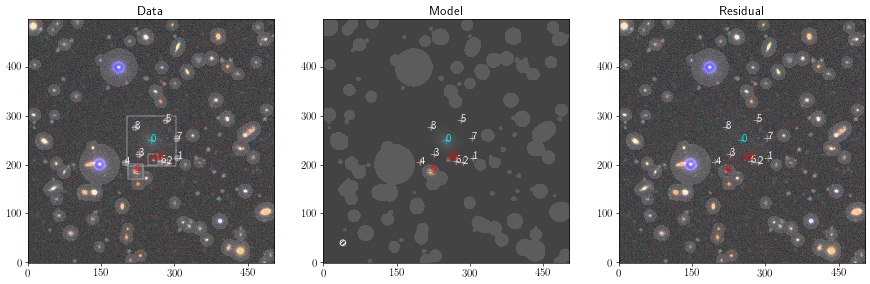

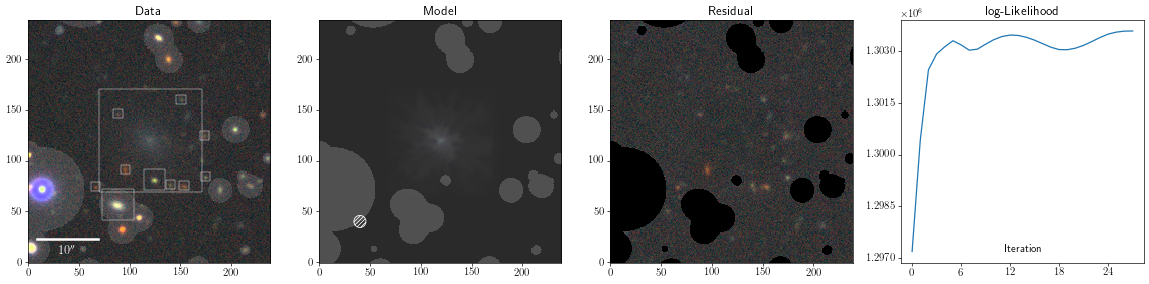

In [13]:
fitting_obs_tigress(env_dict, 
                    lsbg, 
                    name='viz-id',
                    method='vanilla', 
                    prefix='mock', 
                    model_dir='./Model/mock_sample/',
                    figure_dir='./Figure/mock_sample',
                    log_dir='./log/mock_sample',
                    show_figure=True)

In [11]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [12]:
fitter = ScarletFitter(method='wavelet', tigress=True, starlet_thresh=0.5,
                       model_dir='./Model/mock_sample/',
                        figure_dir='./Figure/mock_sample',
                        log_dir='./log/mock_sample',
                       prefix='mock', 
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    3 stars from Gaia are masked!
    Detected 165 objects
    3 stars from Gaia are masked!
    Detected 153 objects
    Detected 83 objects
  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.20, starlet_thresh = 0.50 (contam_ratio = 0.12).
    Total number of sources: 14
    Optimizaiton: Succeed for e_rel = 0.0001 with 36 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 56 iterations! Try higher accuracy!
  - After 56 iterations, logL = 1289255.29
    Elapsed time for fitting: 19.71 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /tigress/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-9-trained-model-wavelet.df


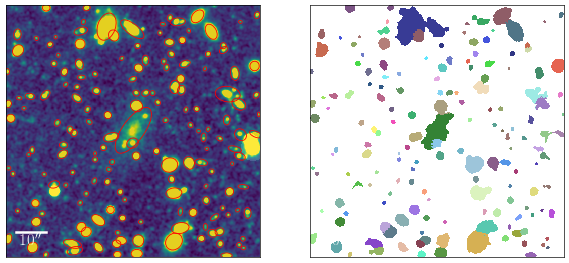

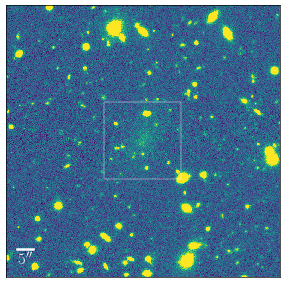

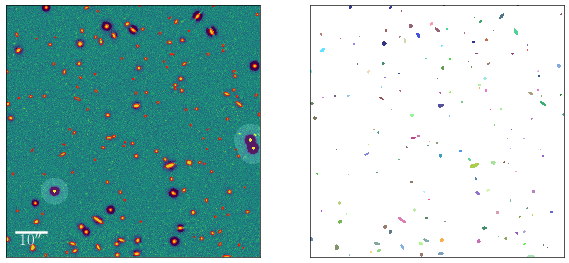

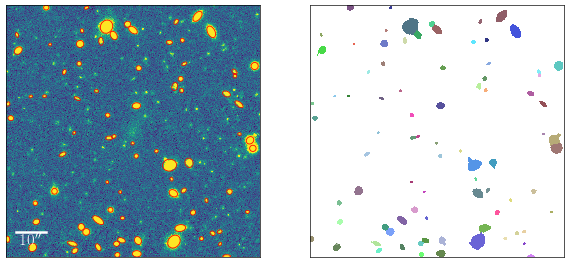

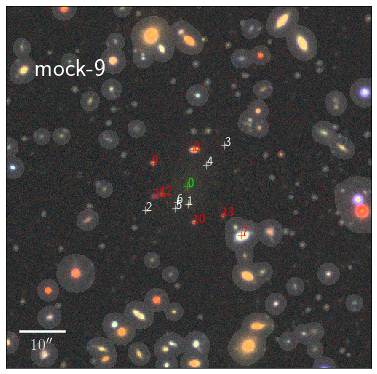

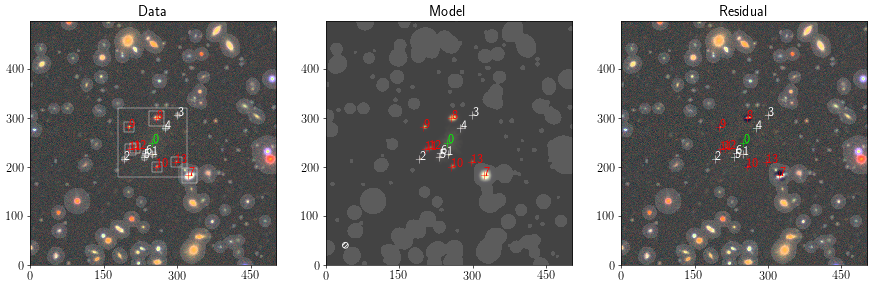

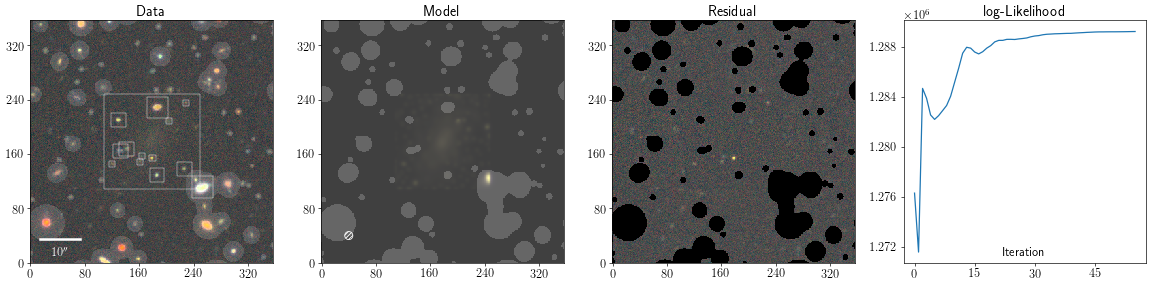

In [16]:
fitter.fit()

#### Step-by-step

In [13]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    3 stars from Gaia are masked!


In [14]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 165 objects


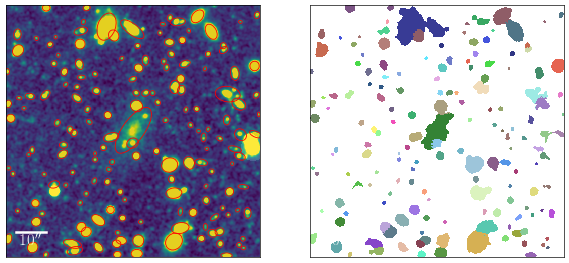

In [15]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.006

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.02
        
fitter._first_detection(first_dblend_cont)

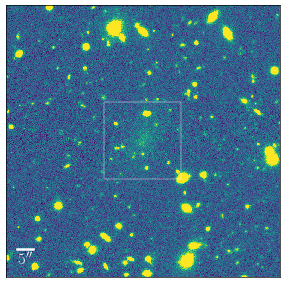

In [59]:
fitter._estimate_box(fitter.cen_obj)

In [60]:
fitter._mask_stars_outside_box()

    3 stars from Gaia are masked!


    Detected 153 objects


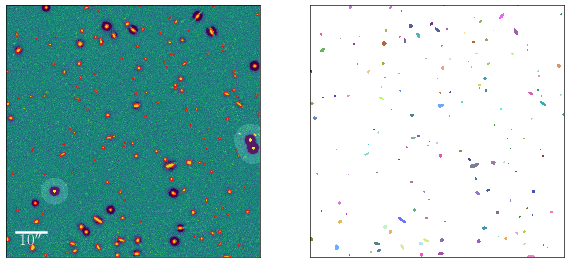

In [61]:
fitter._cpct_obj_detection()

    Detected 83 objects


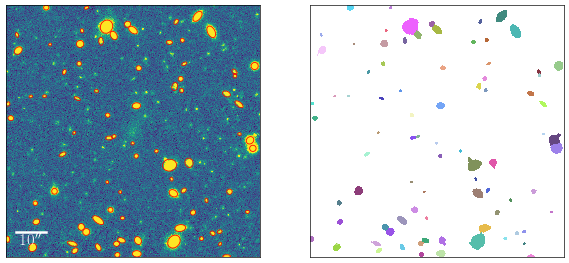

In [62]:
fitter._big_obj_detection()

In [63]:
fitter._merge_catalogs()

In [64]:
fitter._construct_obs_frames()

In [68]:
fitter._add_sources()

  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.20, starlet_thresh = 0.50 (contam_ratio = 0.12).
    Total number of sources: 14


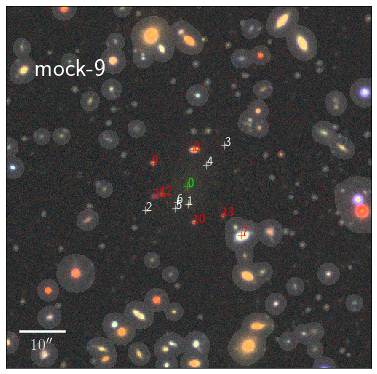

In [69]:
fig = kz.display.display_scarlet_sources(
        fitter.data,
        fitter._sources,
        show_ind=None,
        stretch=1,
        Q=1,
        minimum=-0.3,
        show_mark=True,
        scale_bar_length=10,
        add_text=f'{fitter.prefix}-{fitter.index}')

    Optimizaiton: Succeed for e_rel = 0.0001 with 36 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 56 iterations! Try higher accuracy!
  - After 56 iterations, logL = 1289255.29
    Elapsed time for fitting: 20.88 s


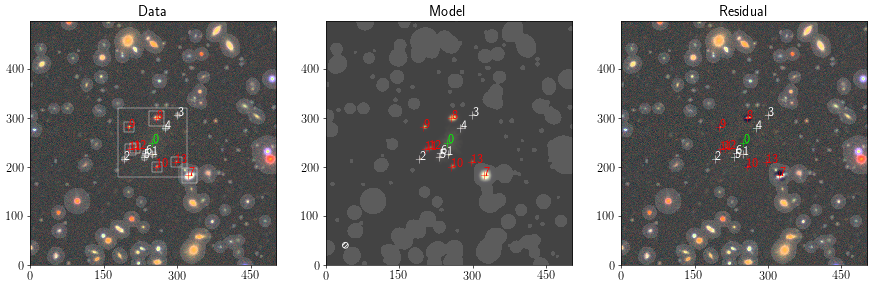

In [70]:
fitter._optimize()

In [71]:
fitter._find_sed_ind()

  - Components [0] are considered as the target galaxy.


In [72]:
fitter._gen_final_mask()

  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /tigress/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-9-trained-model-wavelet.df


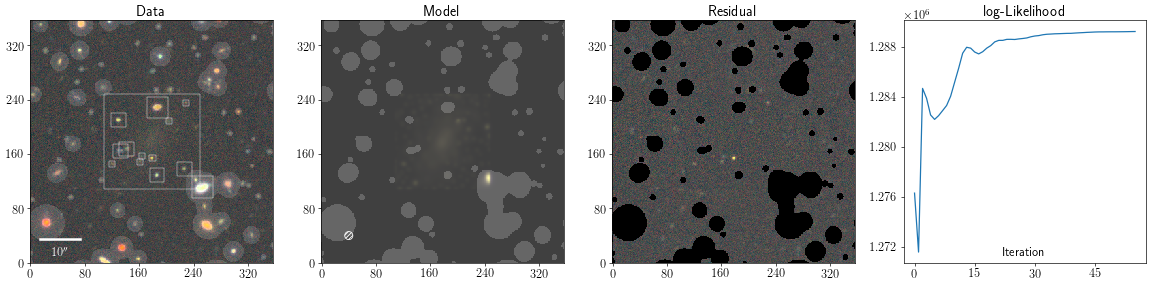

In [73]:
fitter._display_results()